In [8]:
import numpy as np
import sys
sys.path.append('../')
from symmetry_breaking_measure import Nickel, ReflectionOperator
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import pandas as pd
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# The violation of symmetry elements of local distorted Nickel

## Sample Size

In [9]:
# Cubic solid cut off from Nickel (length=1)
NUM_SAMPLES = 50000
NUM_D = 50
NUM_ANGLES = 5
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025

nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
axis=[0,0,1]
origin = nickel.xyz.mean(axis=0)
reflection_op = ReflectionOperator(axis=axis, origin=origin)

atoms_idx_in_plane = np.where(nickel.xyz[:,2] == nickel.xyz[:,2].max()/2)[0]
atoms_idx_out_of_plane = np.where(nickel.xyz[:,2] != nickel.xyz[:,2].max()/2)[0]

In [10]:
def perturbation_0_degree(radius=None, num_of_tests=None):
    phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.zeros(num_of_tests)
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_45_degree(radius=None, num_of_tests=None):
    phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    factor = np.sqrt(2) / 2
    x = np.cos(phi) * factor
    y = np.sin(phi) * factor
    z = np.ones(num_of_tests) * factor
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_90_degree(radius):
    return np.array([[0,0,1]]) * radius

def calc_variance_sample_size_from_nickel(d, idx, perturbation):
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    sample_size, measure = nickel_distorted.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=reflection_op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='KL',
        )
    return measure, sample_size

def construct_tasks_sample_size(angle, in_plane, max_d):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if in_plane:
        atoms_idx_set = atoms_idx_in_plane
    else:
        atoms_idx_set = atoms_idx_out_of_plane
        
    tasks = []
    for d in np.linspace(0,max_d,int(NUM_D*max_d)):
        for idx in atoms_idx_set:
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((d, idx, perturbations[perturbation_idx, :]))
    return tasks

def compute_sample_size(args):
    d, idx, perturbation = args
    measure, sample_size = calc_variance_sample_size_from_nickel(d, idx, perturbation)
    return [d, measure, sample_size]

def read_sample_size(filedir):
    df = pd.read_csv(filedir, usecols=[0, 2])
    df = df.groupby(df.columns[0]).mean().reset_index()
    result = df.values
    return result

In [5]:
#in-plane atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, in_plane=True, max_d=3)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane_samplesize_KL.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 3000/3000 [00:24<00:00, 124.28it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
100%|██████████| 600/600 [00:04<00:00, 130.41it/s]


In [6]:
#out-of-plane atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, in_plane=False, max_d=1.5)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane_samplesize_KL.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 3750/3750 [00:29<00:00, 126.28it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
100%|██████████| 750/750 [00:05<00:00, 125.89it/s]


## Test

In [5]:
def compute_sbm(args):
    idx, d, num_samples, perturbation = args
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    measure = nickel_distorted.calc_symmetry_breaking_measure(num_samples=num_samples, operator=reflection_op, method="KL") 
    return [d, measure]

def construct_tasks(angle, in_plane):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if in_plane:
        atoms_idx_set = atoms_idx_in_plane
    else:
        atoms_idx_set = atoms_idx_out_of_plane
        
    in_plane_str = "in_plane" if in_plane else "out_of_plane"
    sample_sizes = read_sample_size(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_str}_samplesize_KL.csv')
        
    tasks = []
    for i in range(sample_sizes.shape[0]):
        d = sample_sizes[i,0]
        for idx in atoms_idx_set:
            num_samples = max(int(sample_sizes[i,1]), 3000)
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((idx, d, num_samples, perturbations[perturbation_idx, :]))
    return tasks

In [12]:
#in-plane atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 3000/3000 [00:03<00:00, 776.81it/s]


In [5]:
#in-plane atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 3000/3000 [45:53<00:00,  1.09it/s]  


In [5]:
#in-plane atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, in_plane=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_in_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 600/600 [32:15<00:00,  3.23s/it]


In [6]:
#out-of-plane atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 3750/3750 [35:15<00:00,  1.77it/s]


In [7]:
#out-of-plane atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()-4) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 3750/3750 [34:45<00:00,  1.80it/s]


In [8]:
#out-of-plane atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, in_plane=False)
with Pool(processes=cpu_count()-4) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/reflection_perturbation_{angle}_out_of_plane_KL.csv', np.array(measures), delimiter=',')

100%|██████████| 750/750 [06:28<00:00,  1.93it/s] 


# Paper Section 5.1.2

In [1]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel
from colour import Color
from matplotlib import rc

def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

NUM_SAMPLES = 20000
BLUE, RED, GREEN, MIDDLE = '#0B3C5D', '#B82601', '#1c6b0a', '#a8b6c1'

In [3]:
# Load data
# Note: The final data structure will have the form data[angle][in_plane_key][sample_size_key]['x or y or color or linestyle']
def initialize_data_structure():
    """Initializes the nested dictionary structure for data."""
    return {
        "x": None,
        "y": None,
        "color": None,
        "linestyle": None
    }

data = {}
for angle, color in [[0, BLUE], [45, RED], [90, GREEN]]:
    data[angle] = {}
    for in_plane_key in ['in_plane', 'out_of_plane']:
        data[angle][in_plane_key] = {}
        for sample_size_key in ['', '_samplesize']:
            data[angle][in_plane_key][sample_size_key] = initialize_data_structure()
            if sample_size_key == '':
                data[angle][in_plane_key][sample_size_key]['x'], data[angle][in_plane_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_key}{sample_size_key}_KL.csv', delimiter=',', usecols=(0,1)).T
            else:
                data[angle][in_plane_key][sample_size_key]['x'] = np.loadtxt(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_key}{sample_size_key}_KL.csv', delimiter=',', usecols=0).T
                data[angle][in_plane_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/reflection_perturbation_{angle}_{in_plane_key}{sample_size_key}_KL.csv', delimiter=',', usecols=2).T
            data[angle][in_plane_key][sample_size_key]['color'] = color

In [25]:
def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

def plot(angle_keys, in_plane_key, sample_size_key, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None, solid=None, extra_data=None):
    fig = plt.figure()
    if style:
        plt.style.use(style)
    fig.set_size_inches(5, 4)
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)

    ax_main = fig.add_subplot()
    for angle in angle_keys:
        d = data[angle][in_plane_key][sample_size_key]
        ax_main.scatter(d['x'], d['y'], s=1.5, color=d['color'], alpha=0.8)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    
    if extra_data:
        for d in extra_data:
            ax_main.plot(d['x'], d['y'], linestyle=d['linestyle'], color=d['color'], alpha=0.8)

    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'])
        ax_text.set_axis_off()
        
    if solid:
        img = imread(solid['directory'])
        ax_rectangular_solid = fig.add_axes(solid['loc'])
        ax_rectangular_solid.imshow(img)
        ax_rectangular_solid.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def plot_solid(lim, in_plane=True, filename=None, style=None):
    # Cubic solid cut off from Nickel (length=1)
    nickel = Nickel(cutoff='rectangular_solid', x=1, y=1, z=1)
    samples = nickel._finite_cluster.generate_samples(NUM_SAMPLES)
    
    fig = plt.figure() 
    ax = fig.add_subplot(projection="3d")
    if style:
        plt.style.use(style)

    cmap_blue = make_Ramp([MIDDLE, BLUE])
    ax = nickel.plot_rectangular_solid(ax=ax, samples=samples, cmap=cmap_blue, facecolor=BLUE, in_plane=in_plane)

    xx, yy = np.meshgrid(np.linspace(0, 3.52, 10), np.linspace(0, 3.52, 10))
    z = np.ones((10,10)) * 1.76
    ax.plot_surface(xx, yy, z, color=BLUE, alpha=.5)

    ax.set_xlim(lim['x'][0],lim['x'][1])
    ax.set_ylim(lim['y'][0],lim['y'][1])
    ax.set_zlim(lim['z'][0],lim['z'][1])
    ax.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def find_local_minima(angle, in_plane_key, sample_size_key):
    d = data[angle][in_plane_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) > 0) & (np.hstack([0, diff]) < 0))[0]
    return d['x'][idx], d['y'][idx]

def find_local_maxima(angle, in_plane_key, sample_size_key):
    d = data[angle][in_plane_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) < 0) & (np.hstack([0, diff]) > 0))[0]
    return d['x'][idx], d['y'][idx]

In [37]:
data[45]['in_plane']['']['y'].size

3000

In [38]:
np.argmin(data[45]['in_plane']['']['y'][1500:])

985

In [39]:
min(data[45]['in_plane']['']['y'][1500:])

0.07143206181224751

In [ ]:
# Cubic solid cut off from Nickel (length=1) - in_plane
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, in_plane=True, filename='../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', style=bg_mpl_style)

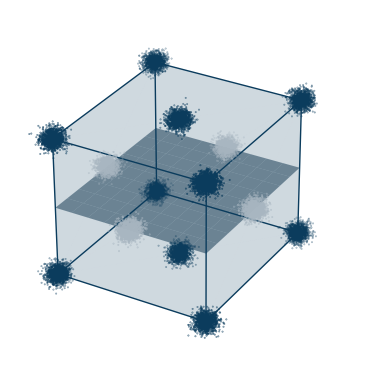

In [5]:
# Cubic solid cut off from Nickel (length=1) - out_of_plane
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, in_plane=False, filename='../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', style=bg_mpl_style)

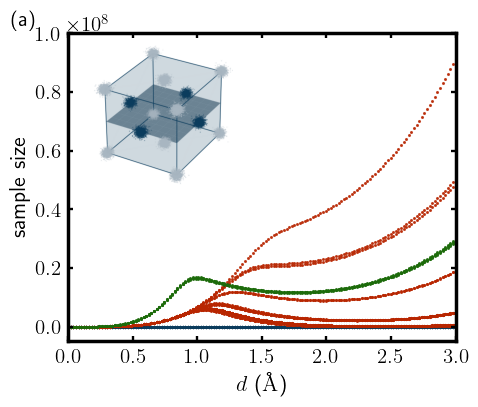

In [33]:
# sample size - in_plane
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,3], ylim=[-5000000,100000000], 
     filename='../figs/nickel/reflection_in_plane_samplesize_KL.png', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[0.01, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', 'loc':[0.14, 0.5, 0.35, 0.35]})

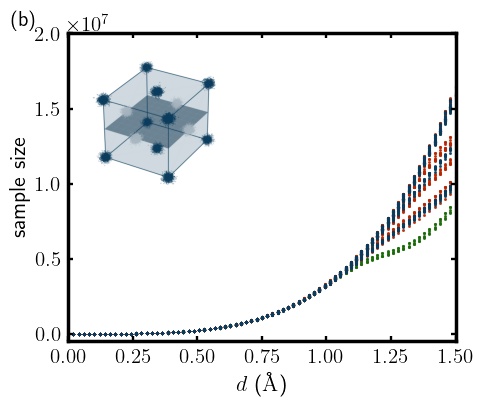

In [34]:
# sample size - out_of_plane
plot(angle_keys=[90, 45 ,0], in_plane_key='out_of_plane', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,1.5], ylim=[-500000,20000000], 
     filename='../figs/nickel/reflection_out_of_plane_samplesize_KL.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[0.01, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', 'loc':[0.15, 0.44, 0.33, 0.43]})

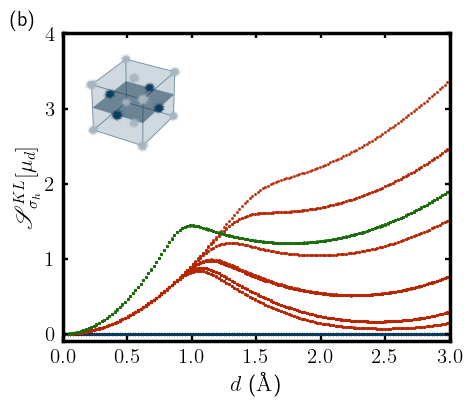

In [35]:
# in-plane
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='', 
     #xlabel=r'd ($\mathrm{\AA}$)', ylabel='$\mathscr{S}_{\sigma_h}[\mu_d]$', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{KL}_{\sigma_h}[\mu_d]$',
     xlim=[0,3], ylim=[-0.1,4], 
     filename='../figs/nickel/reflection_in_plane_KL.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[0.02, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.png', 'loc':[0.14, 0.58, 0.25, 0.25]})

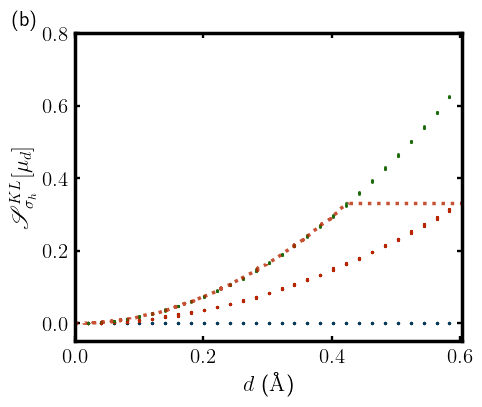

In [36]:
# in-plane - sqrt2
x_max = 600
dx, dy = data[45]['in_plane']['']['x'], data[45]['in_plane']['']['y']
line_1 = {'x':dx[:x_max+1]/np.sqrt(2), 'y':dy[:x_max+1], 'linestyle': ':', 'color': RED}
line_2 = {'x':[dx[x_max]/np.sqrt(2), dx[x_max]], 'y':[dy[x_max],dy[x_max]], 'linestyle': ':', 'color': RED}
extra_data = [line_1, line_2]
plot(angle_keys=[0,45,90], in_plane_key='in_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{KL}_{\sigma_h}[\mu_d]$',
     xlim=[0,data[45]['in_plane']['']['x'][x_max]], ylim=[-0.05,0.8], 
     filename='../figs/nickel/reflection_in_plane_sqrt2_KL.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[0.00, .9, 0, 0]}, 
     solid=None, extra_data=extra_data)

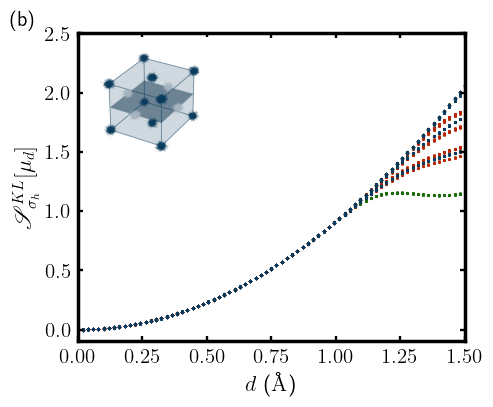

In [37]:
# out-of-plane
plot(angle_keys=[90, 45 ,0], in_plane_key='out_of_plane', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{KL}_{\sigma_h}[\mu_d]$',
     xlim=[0,1.5], ylim=[-0.1,2.5], 
     filename='../figs/nickel/reflection_out_of_plane_KL.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.01, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.png', 'loc':[0.12, 0.54, 0.33, 0.33]})